In [2]:
import numpy as np
import pandas as pd
import random
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats
from tqdm.notebook import tqdm
from tqdm import tqdm
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [3]:
birth_data = pd.read_csv('BRa1989-2014.txt')
birth_data

,Year,Reg,Group,Bra15,Bra16,Bra17,Bra18,Bra19,Bra20,Bra21,...,Bra46,Bra47,Bra48,Bra49,Bra50,Bra51,Bra52,Bra53,Bra54,Bra55
0,1989,1100,T,1838,10395,34222,80966,140650,174445,179922,...,268,102,64,40,14,9,12,4,6,23
1,1989,1100,U,1393,8683,27761,66238,122468,155277,163202,...,178,63,29,28,10,3,10,4,2,13
2,1989,1100,R,3091,15822,63770,155175,216754,244637,236743,...,551,225,172,74,26,26,21,4,17,46
3,1989,3000,T,1586,8309,28296,68582,124826,155651,160451,...,171,57,32,13,0,3,10,0,9,5
4,1989,3000,U,1166,6463,22589,56978,110402,141810,149330,...,140,62,13,17,0,4,12,0,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7171,2014,1199,U,5676,11019,32997,64885,72758,85987,93999,...,0,0,0,0,0,0,0,0,0,0
7172,2014,1199,R,9885,20548,60120,126362,141700,224215,224439,...,0,0,0,0,0,0,0,0,0,0
7173,2014,1177,T,6359,25357,56198,54845,73298,113590,142857,...,0,0,0,0,0,0,0,0,0,0
7174,2014,1177,U,5263,5376,20997,10204,45558,67885,83086,...,0,0,0,0,0,0,0,0,0,0


In [4]:
birth_data[birth_data.columns[3:]].iloc[9].apply(lambda x: int(x)).sum()/1e6

2.107942

In [5]:
def preprocess_birth_data(birth_data):
    
    birth_data_msc = birth_data[birth_data['Reg'] == 1145]
    birth_data_mo = birth_data[birth_data['Reg'] == 1146]
    birth_data = pd.concat([birth_data_msc,birth_data_mo],axis = 0)
    #birth_data = birth_data_msc
    
    birth_data = birth_data[birth_data['Group'] == 'T']
    del birth_data['Group']
    
    for cols in birth_data.columns[2:]:
        birth_data[cols] = birth_data[cols].apply(lambda x: int(x)/2)
        
    #birth_data = birth_data[birth_data['Year']>= 1999]
        
    birth_data = birth_data.groupby('Year').sum()
    
    del birth_data['Reg']
    
    
    
    return birth_data.T




data = preprocess_birth_data(birth_data)

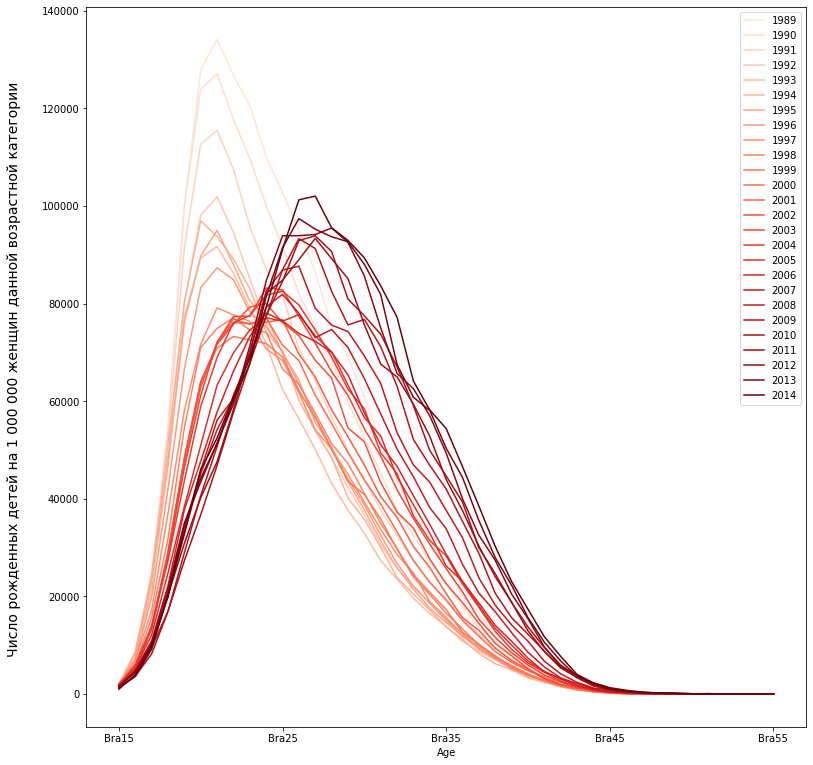

In [6]:
import cycler

s = 25 
color2 = plt.cm.Reds(np.linspace(0.1, 1,s+1))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color2)
fig = plt.figure(figsize = (10,10))
ax = fig.add_axes([0,0,1,1])
plt.xticks([0,10,20,30,40,50])
ax.set_xlabel('Age')
ax.set_ylabel('Число рожденных детей на 1 000 000 женщин данной возрастной категории \n',fontsize = 14)
for col in data.columns:
    plt.plot(data[col],label = str(col))
plt.legend();

In [7]:
data.tail()

Year,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Bra51,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,...,11.5,27.0,32.0,37.0,82.5,23.0,28.0,26.0,58.0,90.0
Bra52,24.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,...,6.0,11.5,5.5,26.5,26.5,5.0,10.0,21.5,18.0,23.5
Bra53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,...,0.0,6.0,6.0,0.0,5.5,16.0,18.5,34.5,18.0,49.0
Bra54,12.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.5,...,0.0,0.0,0.0,17.0,19.0,13.5,10.5,15.0,29.5,13.5
Bra55,10.5,0.0,0.0,0.0,0.0,0.0,0.0,7.5,9.5,15.0,...,6.0,42.5,15.0,6.0,5.5,5.5,16.0,13.5,25.0,21.5


### Реализация гамма-модели

In [8]:
data['x'] = np.arange(15,56)
data.head()

Year,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,x
Bra15,1411.0,1972.5,1771.0,1556.5,1594.5,1834.5,1774.5,1866.0,2106.0,1663.0,...,1641.0,1776.0,1487.0,1264.5,1290.0,1624.5,1525.5,1395.0,1011.0,15
Bra16,7008.5,8693.5,8481.0,7231.5,7002.5,8568.0,8153.5,7069.0,7058.0,5955.5,...,4875.0,4581.5,4670.0,3595.0,3655.5,4363.5,4723.5,3655.5,3978.5,16
Bra17,23105.0,23811.5,24610.0,21983.5,21646.5,24244.5,23457.5,19832.5,17144.5,15637.0,...,10903.5,9782.0,10701.5,9480.0,8228.5,10202.0,10525.5,9161.0,9790.0,17
Bra18,54358.5,54656.0,52570.5,48906.0,46566.0,51122.5,47514.0,42001.0,36985.0,31893.0,...,22233.0,20898.5,19921.5,16917.0,16914.0,20288.0,21716.0,20238.0,19961.5,18
Bra19,99877.5,99949.5,91435.0,80105.0,77295.0,80271.0,76133.5,66575.0,58087.0,54495.0,...,37715.5,32763.0,33937.5,28934.5,27323.5,30868.0,35031.0,34739.5,32986.0,19


In [9]:
data[2014].sum()/1e6

1.469723

In [10]:


x = np.array(data['x'])
x_minus_15 = x  # избегаем проблем с логарифмом от нуля
#print(x_minus_15[:5])
log_x_minus_15 = np.log(x_minus_15)
intercept = np.ones(len(x_minus_15))

def transpose(array):
    return np.array(pd.DataFrame(array).T)
X = np.array([intercept,log_x_minus_15,x_minus_15])
X = transpose(X)

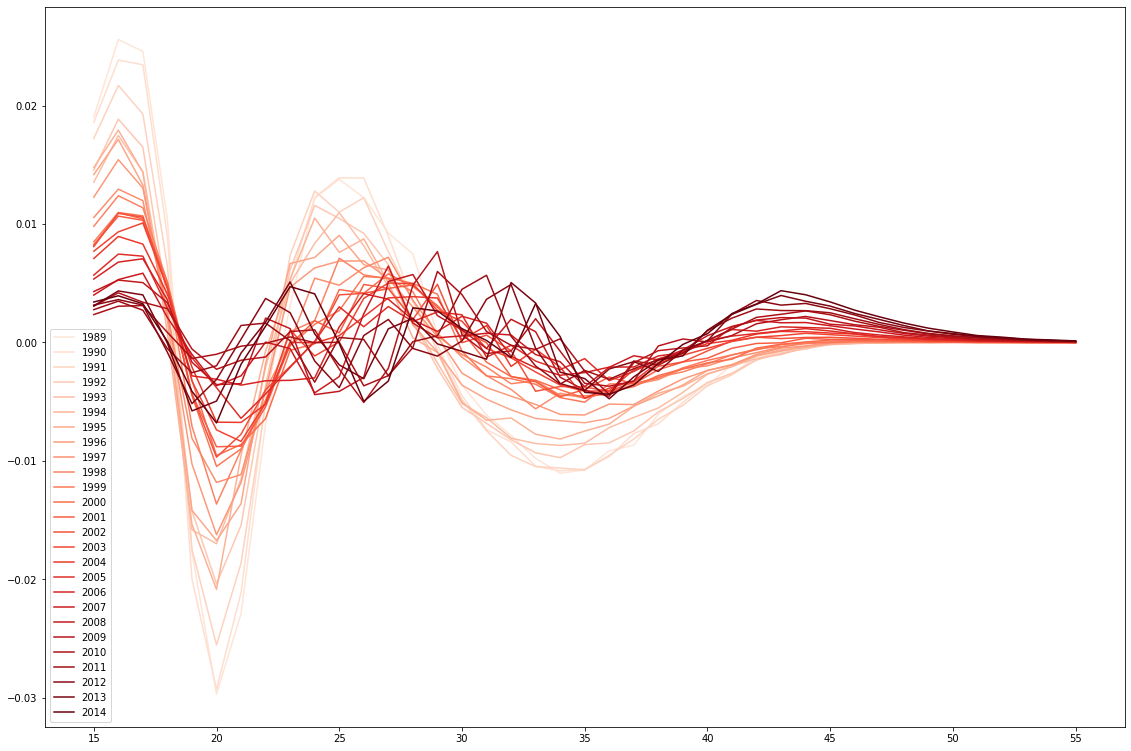

In [11]:
'''
Подбираем оптимальные параметры численно, задав семейство кривых. Эконометрический способ оценки описан в теле работы.

'''


from scipy.optimize import curve_fit
import math

fig = plt.figure(figsize = (15,10))
ax = fig.add_axes([0,0,1,1])
params = []

vec = []
counter = 0
lst = list(data.columns)
lst.remove('x')
for col in lst:

    y = data[col] 

    y = y/1e6


    x = np.arange(15,56)
    
    '''
    возьмем параметры нормального распределения в качестве начальной точки поиска решения, так просто быстрее, чем начинать со случайной точки
    
    '''

    

    def gamma(x,a1,a2,a3):
        f = (a1/math.gamma(a3)) * (a2**a3) * ((x_minus_15)**(a3-1)) * np.exp(-a2*(x_minus_15))
        return f

    popt,pcov = curve_fit(gamma,x,y,p0=[1,0.9,25]);
    params.append(popt)

    ax.plot(x,gamma(x_minus_15,*popt) - y,label = col);
    vec.append(np.array(gamma(x_minus_15,*popt) - y));
    counter+=1
    
    plt.legend()



### Работаем непосредственно с кривыми, предсказываем параметры

In [12]:
params = np.log(transpose(params))
print(params)

[[ 4.41406839e-01  3.47707528e-01  2.15943271e-01  6.18843860e-02
  -2.55502848e-02  4.32622182e-02  5.52429563e-02  2.71127868e-02
  -1.28222739e-02 -1.16194954e-02 -4.89884672e-02  1.33967931e-02
   5.23261571e-02  9.82728711e-02  1.43059734e-01  1.59098871e-01
   1.25992072e-01  1.17144039e-01  1.53744675e-01  2.16372158e-01
   2.58962687e-01  2.84085053e-01  2.91795319e-01  3.59791043e-01
   3.71369732e-01  4.03867664e-01]
 [-7.01489489e-02 -4.28772868e-02 -1.61917162e-03  5.79654678e-02
   6.84063235e-02  3.28155888e-02 -1.60121591e-02 -4.93961900e-02
  -1.11563398e-01 -1.17007953e-01 -1.07047467e-01 -1.25616181e-01
  -1.64793474e-01 -1.91680678e-01 -2.08116419e-01 -2.26764937e-01
  -2.34358206e-01 -2.42412060e-01 -2.39685499e-01 -2.52006977e-01
  -2.17734708e-01 -2.10555670e-01 -2.45168545e-01 -2.59122753e-01
  -2.68302186e-01 -2.77094767e-01]
 [ 3.12048744e+00  3.13372230e+00  3.16324830e+00  3.21451589e+00
   3.22104236e+00  3.18857697e+00  3.15248913e+00  3.13351355e+00
   3.0


 Наилучшая ARIMA : [1, 1, 0]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   26
Model:               SARIMAX(1, 1, 0)   Log Likelihood                  40.709
Date:                Thu, 07 May 2020   AIC                            -77.417
Time:                        20:46:01   BIC                            -74.979
Sample:                             0   HQIC                           -76.741
                                 - 26                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6340      0.138      4.601      0.000       0.364       0.904
sigma2         0.0022      0.001      3.589      0.000       0.001       0.003
Ljung-Box (Q):        

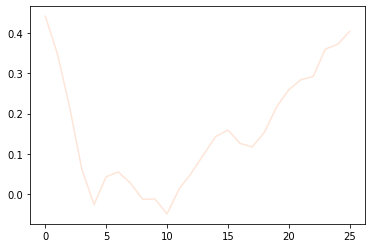

In [13]:
import statsmodels.api as sm

'''
Обработка одного временного ряда на примере первого. Логарифмирование произвели для того, чтобы избавиться от нестационарности в дисперсии.
'''

plt.plot((params)[0]);

'''
Видим, что динамика ряда существенно изменилась в рамках исследуемого периода, однако если ряд обрезать, опт.модель не изменится, лаги творят чудеса

'''

'''
Устраиваем процедуру перебора по AIC
'''

vect = []
vect.append([[a,b,c] for a in range(0,3) for b in range(1,3) for c in range(0,3)])
quality_vect = []

y = params[0]
for i in vect[0]:
    model = sm.tsa.statespace.SARIMAX(y, order = i).fit(disp=-1)
    #print(best_model.summary())
    quality_vect.append(model.aic)
    
optimal_parameters = vect[0][np.argmin(quality_vect)]
print('\n Наилучшая ARIMA : {}'.format(optimal_parameters))

best_model = sm.tsa.statespace.SARIMAX(y, order = optimal_parameters).fit(disp=-1)
print(best_model.summary())

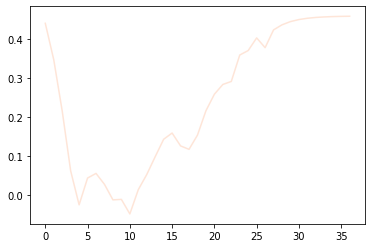

In [14]:
'''
Предсказываем на 10 периодов вперед
'''
forecast_0 = best_model.predict(25,35)
t = np.append(y,forecast_0)
plt.plot(t)


In [15]:
'''!pip install pyramid-arima
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(y, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=1,
                         start_P=0, seasonal=False,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

fitted = best_model.predict(n_periods=30, return_conf_int=False)
plt.plot(fitted)'''

"!pip install pyramid-arima\nimport pmdarima as pm\n\n# Seasonal - fit stepwise auto-ARIMA\nsmodel = pm.auto_arima(y, start_p=1, start_q=1,\n                         test='adf',\n                         max_p=3, max_q=3, m=1,\n                         start_P=0, seasonal=False,\n                         d=None, D=1, trace=True,\n                         error_action='ignore',  \n                         suppress_warnings=True, \n                         stepwise=True)\n\nsmodel.summary()\n\nfitted = best_model.predict(n_periods=30, return_conf_int=False)\nplt.plot(fitted)"


 Наилучшая ARIMA : [1, 1, 0]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   26
Model:               SARIMAX(1, 1, 0)   Log Likelihood                  58.193
Date:                Thu, 07 May 2020   AIC                           -112.386
Time:                        20:46:03   BIC                           -109.948
Sample:                             0   HQIC                          -111.710
                                 - 26                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5847      0.155      3.782      0.000       0.282       0.888
sigma2         0.0005      0.000      2.768      0.006       0.000       0.001
Ljung-Box (Q):        

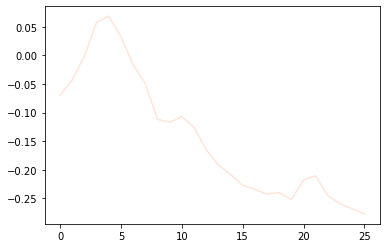

In [16]:
'''
Обработка одного временного ряда на примере первого. Логарифмирование произвели для того, чтобы избавиться от нестационарности в дисперсии.
'''
y = (params)[1]
plt.plot(y);

'''
Видим, что динамика ряда существенно изменилась в рамках исследуемого периода, однако если ряд обрезать, опт.модель не изменится, лаги творят чудеса

'''

'''
Устраиваем процедуру перебора по AIC

'''

vect = []
vect.append([[a,b,c] for a in range(0,3) for b in range(1,3) for c in range(0,3)])
quality_vect = []

for i in vect[0]:
    model = sm.tsa.statespace.SARIMAX(y, order = i).fit(disp=-1)
    #print(best_model.summary())
    quality_vect.append(model.aic)
    
optimal_parameters = vect[0][np.argmin(quality_vect)]
print('\n Наилучшая ARIMA : {}'.format(optimal_parameters))

best_model = sm.tsa.statespace.SARIMAX(y, order = optimal_parameters).fit(disp=-1)
print(best_model.summary())

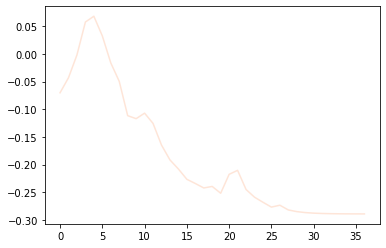

In [17]:
forecast_1 = best_model.predict(25,35)
t = np.append(y,forecast_1)
plt.plot(t)




 Наилучшая ARIMA : [0, 1, 1]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   26
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  59.162
Date:                Thu, 07 May 2020   AIC                           -114.324
Time:                        20:46:04   BIC                           -111.887
Sample:                             0   HQIC                          -113.648
                                 - 26                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4467      0.193      2.312      0.021       0.068       0.825
sigma2         0.0005      0.000      3.719      0.000       0.000       0.001
Ljung-Box (Q):        

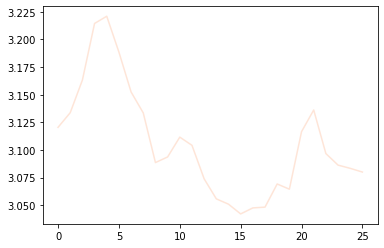

In [18]:
'''
Обработка одного временного ряда на примере первого. Логарифмирование произвели для того, чтобы избавиться от нестационарности в дисперсии.
'''
y = (params)[2]
plt.plot(y);

'''
Видим, что динамика ряда существенно изменилась в рамках исследуемого периода, однако если ряд обрезать, опт.модель не изменится, лаги творят чудеса

'''

'''
Устраиваем процедуру перебора по AIC

'''

vect = []
vect.append([[a,b,c] for a in range(0,3) for b in range(1,3) for c in range(0,3)])
quality_vect = []

for i in vect[0]:
    model = sm.tsa.statespace.SARIMAX(y, order = i).fit(disp=-1)
    #print(best_model.summary())
    quality_vect.append(model.aic)
    
optimal_parameters = vect[0][np.argmin(quality_vect)]
print('\n Наилучшая ARIMA : {}'.format(optimal_parameters))

best_model = sm.tsa.statespace.SARIMAX(y, order = optimal_parameters).fit(disp=-1)
print(best_model.summary())

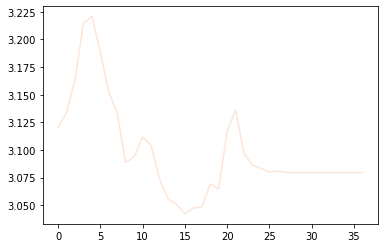

In [19]:
forecast_2 = best_model.predict(25,35)
t = np.append(y,forecast_2)
plt.plot(t)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.0439 , p=0.0003  , df_denom=22, df_num=1
ssr based chi2 test:   chi2=20.5045 , p=0.0000  , df=1
likelihood ratio test: chi2=14.9734 , p=0.0001  , df=1
parameter F test:         F=18.0439 , p=0.0003  , df_denom=22, df_num=1


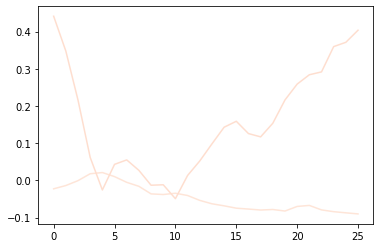

In [20]:
import statsmodels

a = params[0]
b = params[1]/params[2]
plt.plot(b)
plt.plot(a)
statsmodels.tsa.stattools.grangercausalitytests([[a[i], b[i]] for i in range(0, len(a))], 1, verbose=True);

Проблема в потенциальной зависимости оцениваемых параметров, именно из-за нее нам и приходится заниматься поправкой остатков, видим тест Грейнджера чуть выше. Поправка на остатки решит проблему эндогенности.

In [21]:
predicted_params = pd.DataFrame([forecast_0,forecast_1,forecast_2]).T
predicted_params = predicted_params.apply(lambda x: np.exp(x))

### Работаем с отклонениями

In [22]:
# в силу малой апмлитуды колебаний, матрицу можно не центрировать

# аналогично реализации алгоритма в разделе со смертностью, обозначим за $X$ матрицу рассматриваемых отклонений размерности A на T.

# произведем SVD-разлжение этой матрицы и выберем несколько ключевых компонент
X = vec
X = np.array(transpose(X))
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.019043,0.018580,0.017218,0.014545,0.013523,0.014769,0.014173,0.012264,0.010552,0.009804,...,0.005687,0.005352,0.004000,0.004297,0.003061,0.002355,0.002767,0.003159,0.003087,0.003414
1,0.025570,0.023837,0.021697,0.018847,0.017469,0.017929,0.017138,0.015428,0.012941,0.012383,...,0.007459,0.006783,0.005309,0.005264,0.004190,0.003057,0.003487,0.003616,0.004349,0.003938
2,0.024569,0.023437,0.019281,0.016485,0.014406,0.014363,0.013287,0.013038,0.011966,0.011368,...,0.007283,0.007064,0.005845,0.005050,0.003397,0.003114,0.002718,0.003157,0.004012,0.003269
3,0.010359,0.008941,0.006446,0.003329,0.002300,0.000773,0.001883,0.002506,0.002420,0.005076,...,0.002915,0.003595,0.002097,0.003348,0.002849,0.000844,-0.000527,-0.000837,-0.000067,0.000084
4,-0.017713,-0.019967,-0.017446,-0.014227,-0.015808,-0.015351,-0.014168,-0.010266,-0.008090,-0.007075,...,-0.001277,-0.002821,-0.001004,-0.001667,-0.000553,-0.001351,-0.002555,-0.005163,-0.005780,-0.004128


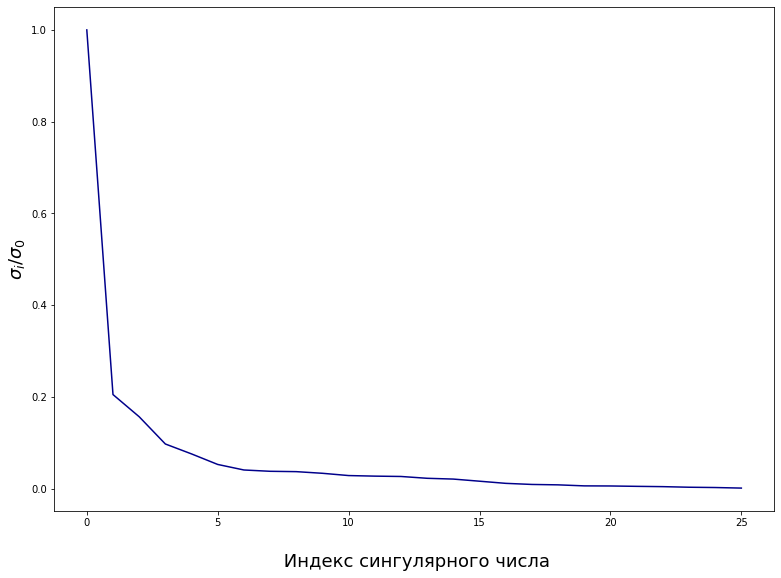

In [23]:
'''
Произвдим сингулярное разложение и следим за убыванием сингулярных чисел, чтобы определить достаточное число главных компонент
'''


B,L,Uh = np.linalg.svd(X,full_matrices=False)

G = np.diag(L)@Uh

fig = plt.figure(figsize = (10,7))
ax = fig.add_axes([0, 0, 1, 1])

plt.plot(L/ L[0],color = 'darkblue')

ax.set_xlabel('\n Индекс сингулярного числа',fontsize = 18)
ax.set_ylabel('$\sigma_i / \sigma_0$',fontsize = 18)
plt.savefig('Сингулярные числа.png')

In [24]:
'''
Функции для нахождения бета- и каппа-векторов
'''


def create_k_beta_vector(k,B = B):
    return B[:,k].reshape(-1,1)


def create_k_kappa_vector(k,G = G):
    return G[k].reshape(1,-1)

def create_k_principal(k,B = B, G = G):
    beta_k = create_k_beta_vector(k)
    kappa_k = create_k_kappa_vector(k)
    return beta_k@kappa_k

def create_approx_k(k):
    M = np.zeros((X.shape[0],X.shape[1]))
    for i in range(k):
        M += create_k_principal(i)
    return M

In [25]:
'''
Качество 3-аппроксимации через норму отклонений
'''

M = create_approx_k(3)
np.linalg.norm(M-X)

0.028564219078346702

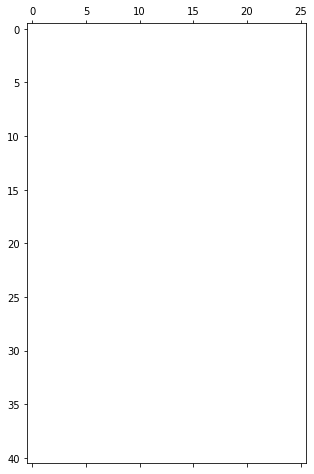

In [26]:
'''
Точность вплоть до 1e-2
'''

plt.figure(figsize = (5,10))
plt.spy(X-M,precision = 0.005); 

In [27]:
'''
убедимся в том, что размерности не поехали
'''

M.shape

(41, 26)

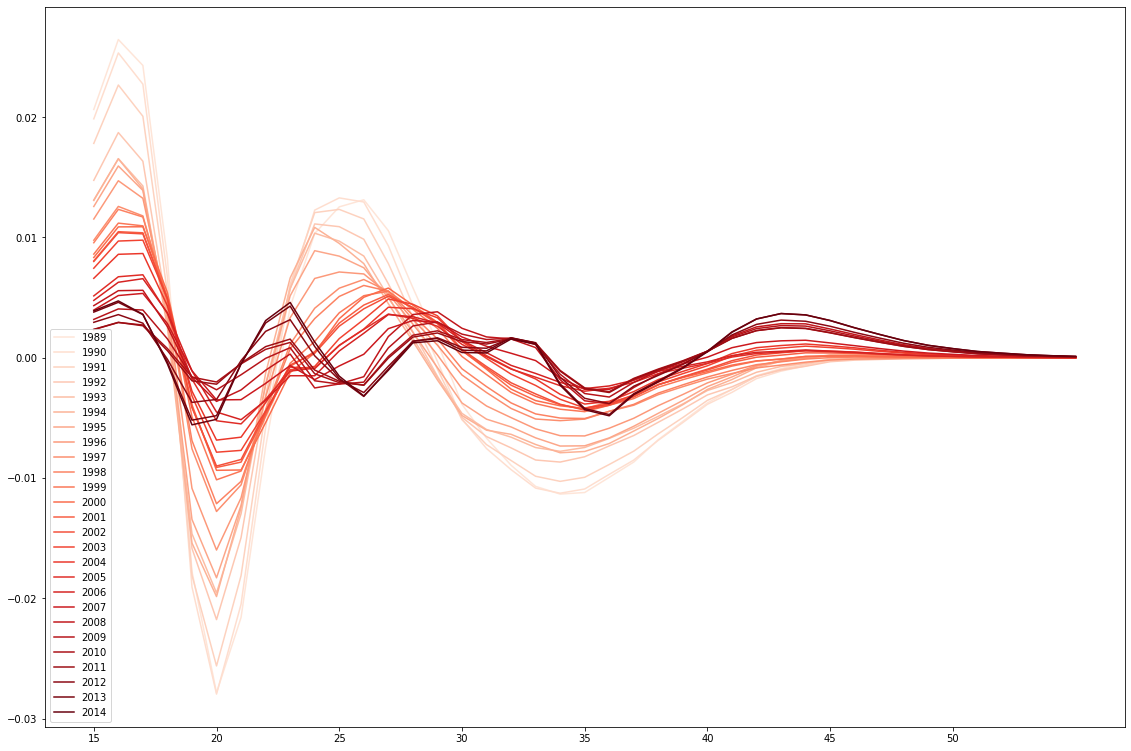

In [28]:
'''
отрисовка приближения
'''


fig = plt.figure(figsize = (15,10))
ax = fig.add_axes([0,0,1,1])
cnt = 0
ax.set_xticks([15 + 5*i for i in range(8)])
for rows in transpose(M):
    ax.plot([15 + i for i in range(41)],rows,label = 1989 + cnt)
    cnt +=1
plt.legend()

In [29]:
''' 
Сохраним в отдельный массив вектора бет и вектора капп, первые, как чувствительности, мы положим постоянными во времени, а каппы спрогнозируем наилучшей по AIC моделью из класса ARIMA.
'''


KAPPA = []

for i in range(3):
    KAPPA.append(create_k_kappa_vector(i))
    

BETAS = []

for i in range(len(KAPPA)):
    BETAS.append(np.array(create_k_beta_vector(i)))


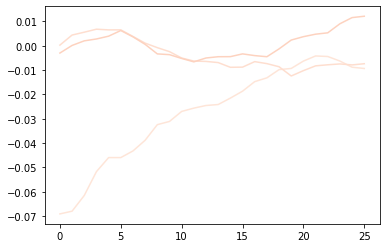

In [30]:
#'посмотрим как ведут себя каппы разных порядков, ожидаем существенной нестационарности от первой'

plt.plot(KAPPA[0][0]);
plt.plot(KAPPA[1][0]);
plt.plot(KAPPA[2][0]);

In [31]:
import statsmodels.api as sm


y = KAPPA[2][0]
best_model = sm.tsa.statespace.SARIMAX(y, order = (0,1,0)).fit(disp=-1)
#print(best_model.summary())
print(best_model.aic)

-235.66600953195746


In [32]:
def compute_theta(row):
    return (row[-1] - row[0])/len(row)

In [33]:
def forecast_kappa(row,n_steps = 1):
    for i in range(n_steps):
        theta = compute_theta(row)
        frc = row[-1] + theta
        row = np.append(row,frc)
    return row

In [34]:
def return_initial_values_of_forecast(n_steps = 1): ## counted per million of population
    f = forecast_kappa(y,n_steps = n_steps)[-1]*BETAS[0]
    return f

In [35]:
def full_forecast(n_steps = 1):
    f1 = forecast_kappa(KAPPA[0][0],n_steps = n_steps)[-1]*BETAS[0]
    f2 = forecast_kappa(KAPPA[1][0],n_steps = n_steps)[-1]*BETAS[1]
    f3 = forecast_kappa(KAPPA[2][0],n_steps = n_steps)[-1]*BETAS[2]
    
    return f1 + f2 + f3

In [36]:
'Собираем прогноз на несколько лет вперед'

def return_residual_forecasts(n_steps = 1):
    vec = []
    for i in range(n_steps):
        vec.append(full_forecast(n_steps = i))
            
    return vec

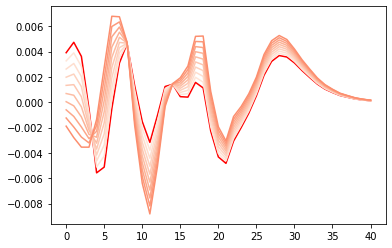

In [37]:
'''
Проверяем есть ли разумная динамика в изменениях остатков в будущем, хотя бы лет на 5
'''

plt.plot(return_residual_forecasts(n_steps = 10)[0],color = 'r')
plt.plot(return_residual_forecasts(n_steps = 10)[1])
plt.plot(return_residual_forecasts(n_steps = 10)[2])
plt.plot(return_residual_forecasts(n_steps = 10)[3])
plt.plot(return_residual_forecasts(n_steps = 10)[4]);
plt.plot(return_residual_forecasts(n_steps = 10)[5]);
plt.plot(return_residual_forecasts(n_steps = 10)[6]);
plt.plot(return_residual_forecasts(n_steps = 10)[7]);
plt.plot(return_residual_forecasts(n_steps = 10)[8]);
plt.plot(return_residual_forecasts(n_steps = 10)[9]);


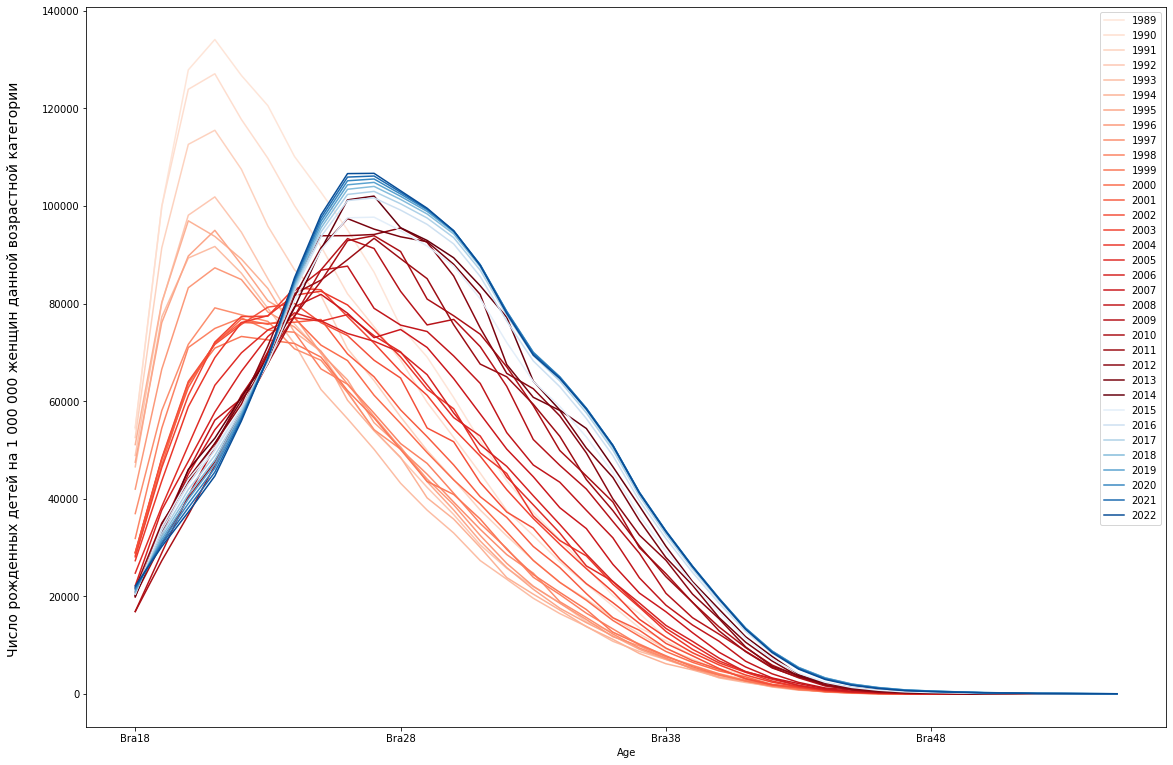

In [38]:
import cycler

s = 25 
color2 = plt.cm.Reds(np.linspace(0.1, 1,s+1))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color2)
fig = plt.figure(figsize = (15,10))
ax = fig.add_axes([0,0,1,1])
plt.xticks([0,10,20,30,40,50])
ax.set_xlabel('Age')
ax.set_ylabel('Число рожденных детей на 1 000 000 женщин данной возрастной категории \n',fontsize = 14)
lst = list(data.columns)
lst.remove('x')
for col in lst:
    ax.plot(data[col][3:],label = str(col))
 
g = 8
color1 = plt.cm.Blues(np.linspace(0.1, 1,g+1))
    
for i in range(8):
    ax.plot(1e6*(gamma(x_minus_15,*predicted_params.iloc[i])[3:] - (return_residual_forecasts(n_steps = 10)[i]).reshape(1,-1)[0][3:]),color = color1[i],label = 2015 + i)
plt.legend();

In [311]:
'''
Собираем все в один файл и правим накопленные ошибки на тонких хвостах (спецификация все-таки оказалась грубоватой :с)
'''

birth_results = []

for i in range(8):
    birth_results.append(1e6*((gamma(x_minus_15,*predicted_params.iloc[i]))))
    
for i in range(len(birth_results)):
    birth_results[i][0] = 1200 + random.randint(-100,100)
    birth_results[i][1] -= 2000 + random.randint(-100,100)

In [312]:
np.round(birth_results)

array([[  1293.,   5930.,  12999.,  19924.,  28638.,  38859.,  50055.,
         61507.,  72398.,  81934.,  89437.,  94432.,  96686.,  96211.,
         93232.,  88139.,  81422.,  73607.,  65205.,  56670.,  48374.,
         40598.,  33530.,  27275.,  21870.,  17298.,  13505.,  10414.,
          7937.,   5981.,   4459.,   3291.,   2405.,   1741.,   1249.,
           888.,    626.,    438.,    304.,    210.,    144.],
       [  1255.,   5820.,  12791.,  19701.,  28458.,  38809.,  50247.,
         62062.,  73435.,  83546.,  91684.,  97326., 100191., 100243.,
         97674.,  92850.,  86252.,  78410.,  69851.,  61051.,  52410.,
         44236.,  36744.,  30061.,  24243.,  19286.,  15144.,  11746.,
          9004.,   6825.,   5118.,   3799.,   2793.,   2033.,   1467.,
          1050.,    745.,    524.,    366.,    254.,    175.],
       [  1289.,   5704.,  12615.,  19474.,  28194.,  38537.,  50007.,
         61905.,  73416.,  83714.,  92076.,  97964., 101076., 101358.,
         98984.,  9430

In [324]:
b_results = pd.DataFrame(np.round(birth_results)/1e6).T

In [325]:
b_results.columns = [2015 + i for i in range(8)]

In [346]:
b_results[2012] = np.array(data[2012]/1e6)
b_results[2011] = np.array(data[2011]/1e6)
b_results[2013] = np.array(data[2013]/1e6)
b_results[2014] = np.array(data[2014]/1e6)

In [348]:
b_results.to_csv('birth_results.csv')